<a href="https://colab.research.google.com/github/sftSalman/pytorch/blob/main/SIGN_language_detection_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader, TensorDataset


def get_data(batch_size=64):
    train_dataset = h5py.File('/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/train_happy.h5', "r")
    x_train = np.array(train_dataset["train_set_x"][:]) # your train set features
    x_train = np.transpose(x_train, (0, 3, 1, 2))
    y_train = np.array(train_dataset["train_set_y"][:]) # your train set labels
    y_train = y_train.reshape((1, y_train.shape[0])).T

    test_dataset = h5py.File('/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/test_happy.h5', "r")
    x_test = np.array(test_dataset["test_set_x"][:]) # your test set features
    x_test = np.transpose(x_test, (0, 3, 1, 2))
    y_test = np.array(test_dataset["test_set_y"][:]) # your test set labels
    y_test = y_test.reshape((1, y_test.shape[0])).T

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    X_train_tensor = torch.tensor(x_train, dtype=torch.float)/255
    Y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_test_tensor = torch.tensor(x_test, dtype=torch.float)/255
    Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


    return train_dataset, test_dataset, train_loader, test_loader, classes


def path_to_input(image_path, input_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (input_size, input_size))                  #Resize
    img = img[..., ::-1].transpose((2, 0, 1))                        #BGR -> RGB and HxWxC -> CxHxW
    img = img[np.newaxis, ...] / 255.0                               #Add a channel at 0, thus making it a batch
    img = torch.tensor(img, dtype=torch.float)        #Convert to Tensor
    return img

In [2]:
#from cnn_utils import *
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from scipy import ndimage


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

%matplotlib inline
np.random.seed(1)

In [3]:
train_dataset, test_dataset, train_loader, test_loader, classes = get_data(batch_size=64)

In [4]:
print(train_dataset)

y = 0


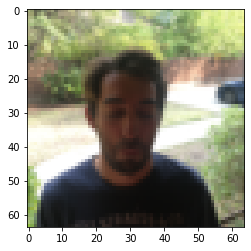

In [5]:
index = 6
img = train_dataset[index][0].numpy().transpose([1, 2, 0])
plt.imshow(img)
print ("y =", str(np.squeeze(train_dataset[index][1].numpy())))

In [6]:
print ("number of training examples =", len(train_dataset))
print ("number of test examples =", len(test_dataset))
print ("shape of a batch of train dataset examples:", next(iter(train_loader))[0].shape)
print ("shape of a batch of train dataset labels:", next(iter(train_loader))[1].shape)

number of training examples = 600
number of test examples = 150
shape of a batch of train dataset examples: torch.Size([64, 3, 64, 64])
shape of a batch of train dataset labels: torch.Size([64, 1])


In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(2048, 6)
)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
def get_accuracy(model, loader):
    model.eval()
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x, y
            y_pred = model(x)
            _, preds = y_pred.data.max(1)
            num_samples += preds.size(0)
            num_correct += (y.view(-1) == preds).sum()
        
    return num_correct.item() / num_samples

In [10]:
def train(model, test_loader, train_loader, epochs = 100, print_every=10):
    model.train()
    for e in range(1, epochs+1):
        if e % print_every == 0:
            print(f'Epoch {e} | Test Accuracy: {get_accuracy(model, test_loader)} | Train Accuracy: {get_accuracy(model, train_loader)}')
        for i, (x, y) in enumerate(train_loader):
            x, y = x, y
            y_pred = model(x)
            loss = loss_fn(y_pred, y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [11]:
train(model, test_loader, train_loader, epochs=100)


Epoch 10 | Test Accuracy: 0.66 | Train Accuracy: 0.61
Epoch 20 | Test Accuracy: 0.6133333333333333 | Train Accuracy: 0.7183333333333334
Epoch 30 | Test Accuracy: 0.6333333333333333 | Train Accuracy: 0.735
Epoch 40 | Test Accuracy: 0.6666666666666666 | Train Accuracy: 0.7516666666666667
Epoch 50 | Test Accuracy: 0.72 | Train Accuracy: 0.81
Epoch 60 | Test Accuracy: 0.7333333333333333 | Train Accuracy: 0.8466666666666667
Epoch 70 | Test Accuracy: 0.8333333333333334 | Train Accuracy: 0.865
Epoch 80 | Test Accuracy: 0.84 | Train Accuracy: 0.8916666666666667
Epoch 90 | Test Accuracy: 0.9 | Train Accuracy: 0.9066666666666666
Epoch 100 | Test Accuracy: 0.9 | Train Accuracy: 0.9083333333333333


Predicted class: 1


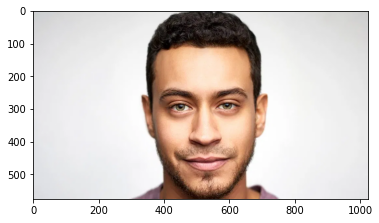

In [13]:
im_path = "/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/1.jpg"
#/content/drive/MyDrive/Deep Learning/pytorch/images/1.jpg
plt.imshow(plt.imread(im_path))

inp = path_to_input(im_path, 64)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print('Predicted class:', y_pred_cls[0].item())

Predicted class: 1


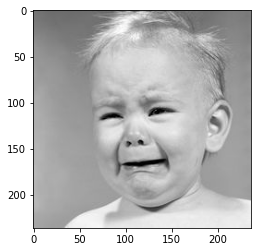

In [14]:
im_path = "/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/2.jpg"
#/content/drive/MyDrive/Deep Learning/pytorch/images/1.jpg
plt.imshow(plt.imread(im_path))

inp = path_to_input(im_path, 64)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print('Predicted class:', y_pred_cls[0].item())

Predicted class: 1


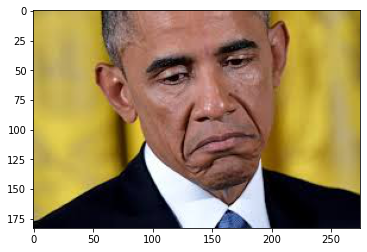

In [15]:
im_path = "/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/3.jpg"
#/content/drive/MyDrive/Deep Learning/pytorch/images/1.jpg
plt.imshow(plt.imread(im_path))

inp = path_to_input(im_path, 64)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print('Predicted class:', y_pred_cls[0].item())

In [16]:
def predict(model, image_tensor):
    model.eval()
    y_pred = torch.sigmoid(model(image_tensor))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred

ValueError: ignored

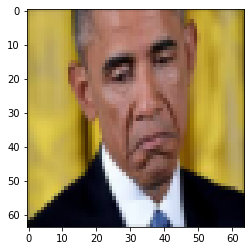

In [18]:
from skimage.transform import resize
fname = "/content/drive/MyDrive/Deep Learning/pytorch/Happy_House/3.jpg"
image = np.array(plt.imread(fname))
my_image = resize(image, (64,64), mode='constant')
plt.imshow(my_image)

image_tensor = torch.tensor(my_image.transpose(2, 0, 1), dtype=torch.float)

y_pred = predict(model, image_tensor.view(1, 3, 64, 64))

if y_pred.item() == 1:
    print('Prediction: Happy')
else:
    print('Prediction: Unhappy')
    